### Random forests regressor (norm) 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
import string
import re

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


data_01=pd.read_csv('Emo_Bank_VAD.csv')

print(data_01.columns)
print('')
print(data_01.shape)
print(data_01.head())
print('')
print(data_01.dtypes)

Index(['id', 'split', 'V', 'A', 'D', 'text'], dtype='object')

(9906, 6)
                    id  split     V     A     D  \
0  110CYL068_1036_1079  train  3.00  3.00  3.20   
1  110CYL068_1079_1110   test  2.80  3.10  2.80   
2  110CYL068_1127_1130  train  3.00  3.00  3.00   
3  110CYL068_1137_1188  train  3.44  3.00  3.22   
4  110CYL068_1189_1328  train  3.55  3.27  3.46   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                                .."  
3  Goodwill helps people get off of public assist...  
4  Sherry learned through our Future Works class ...  

id        object
split     object
V        float64
A        float64
D        float64
text      object
dtype: object


In [2]:
# Text Preprocessing: Lowercase, punctuation removal, and regex cleaning
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(f"[{string.punctuation}]", "", text) 
    return text

data_01["text"] = data_01["text"].apply(preprocess_text)


# Normalize columns 'A', 'V', and 'D'
scaler = MinMaxScaler(feature_range=(-1, 1))

# Apply the scaler to the columns of interest
data_01[['A', 'V', 'D']] = scaler.fit_transform(data_01[['A', 'V', 'D']])


print(data_01.head())

                    id  split         V         A         D  \
0  110CYL068_1036_1079  train  0.058824 -0.076923  0.173554   
1  110CYL068_1079_1110   test -0.058824  0.000000 -0.157025   
2  110CYL068_1127_1130  train  0.058824 -0.076923  0.008264   
3  110CYL068_1137_1188  train  0.317647 -0.076923  0.190083   
4  110CYL068_1189_1328  train  0.382353  0.130769  0.388430   

                                                text  
0          remember what she said in my last letter   
1                            if i wasnt working here  
2                                                     
3  goodwill helps people get off of public assist...  
4  sherry learned through our future works class ...  


In [3]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(data_01["text"], data_01[["V", "A", "D"]], test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)
print("Data shapes:", x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

#Vectorize "text" data
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train)
x_val_tfidf = tfidf.transform(x_val)
x_test_tfidf = tfidf.transform(x_test)


Data shapes: (8023,) (892,) (991,) (8023, 3) (892, 3) (991, 3)


In [4]:
# Initialize the Random Forest Regressor with n_jobs=1 to avoid threading issues
rf = RandomForestRegressor(random_state=42, n_jobs=1)

# Use MultiOutputRegressor to predict multiple outputs
multi_rf = MultiOutputRegressor(rf)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'estimator__n_estimators': [50, 100],  # Fewer trees
    'estimator__max_depth': [None, 10],  # Limit depth
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV for hyperparameter tuning with fewer jobs
grid_search = GridSearchCV(
    estimator=multi_rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores for parallel processing
    verbose=1
)

# Train the model with hyperparameter tuning
grid_search.fit(x_train_tfidf, y_train)

# Get the best parameters from the GridSearchCV
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best estimator for predictions
best_model = grid_search.best_estimator_




# Predict on training, validation, and test datasets
y_train_pred =best_model.predict(x_train_tfidf)
y_val_pred = best_model.predict(x_val_tfidf)
y_test_pred = best_model.predict(x_test_tfidf)

# Convert targets and predictions to numpy arrays 
y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()
y_test_np = y_test.to_numpy()

y_train_pred_np = np.array(y_train_pred)
y_val_pred_np = np.array(y_val_pred)
y_test_pred_np = np.array(y_test_pred)


# Evaluate the model performance using RMSE, MSE, and MAE
def evaluate_performance(y_true, y_pred):
    metrics = {}
    metrics['RMSE_V'] = rmse(y_true[:, 0], y_pred[:, 0])
    metrics['RMSE_A'] = rmse(y_true[:, 1], y_pred[:, 1])
    metrics['RMSE_D'] = rmse(y_true[:, 2], y_pred[:, 2])
    
    metrics['MAE_V'] = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    metrics['MAE_A'] = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    metrics['MAE_D'] = mean_absolute_error(y_true[:, 2], y_pred[:, 2])
    
    metrics['MSE_V'] = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    metrics['MSE_A'] = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    metrics['MSE_D'] = mean_squared_error(y_true[:, 2], y_pred[:, 2])
    
    return metrics

# Calculate performance metrics for train, validation, and test datasets
train_metrics = evaluate_performance(y_train_np, y_train_pred_np)
val_metrics = evaluate_performance(y_val_np, y_val_pred_np)
test_metrics = evaluate_performance(y_test_np, y_test_pred_np)


print(f'Best parameters: {grid_search.best_params_}\n')

print("Train Dataset:")
print(f'RMSE for V: {round(train_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(train_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(train_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(train_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(train_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(train_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(train_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(train_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(train_metrics["MSE_D"], 2)}\n')

print("Validation Dataset:")
print(f'RMSE for V: {round(val_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(val_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(val_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(val_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(val_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(val_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(val_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(val_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(val_metrics["MSE_D"], 2)}\n')

print("Test Dataset:")
print(f'RMSE for V: {round(test_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(test_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(test_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(test_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(test_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(test_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(test_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(test_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(test_metrics["MSE_D"], 2)}\n')




Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best hyperparameters: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}
Best parameters: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}

Train Dataset:
RMSE for V: 0.07
RMSE for A: 0.08
RMSE for D: 0.07

MAE for V: 0.05
MAE for A: 0.06
MAE for D: 0.05

MSE for V: 0.01
MSE for A: 0.01
MSE for D: 0.01

Validation Dataset:
RMSE for V: 0.18
RMSE for A: 0.2
RMSE for D: 0.18

MAE for V: 0.13
MAE for A: 0.15
MAE for D: 0.14

MSE for V: 0.03
MSE for A: 0.04
MSE for D: 0.03

Test Dataset:
RMSE for V: 0.18
RMSE for A: 0.2
RMSE for D: 0.18

MAE for V: 0.13
MAE for A: 0.15
MAE for D: 0.13

MSE for V: 0.03
MSE for A: 0.04
MSE for D: 0.03



In [8]:
#Create tables to compare predicted and real values

# Convert predictions to DataFrames and round to two decimals
y_train_pred_df = pd.DataFrame(y_train_pred, columns=["V_pred", "A_pred", "D_pred"])
y_val_pred_df = pd.DataFrame(y_val_pred, columns=["V_pred", "A_pred", "D_pred"])
y_test_pred_df = pd.DataFrame(y_test_pred, columns=["V_pred", "A_pred", "D_pred"])

# Concatenate real and predicted values
train_comparison = pd.concat([y_train.reset_index(drop=True), y_train_pred_df], axis=1)
val_comparison = pd.concat([y_val.reset_index(drop=True), y_val_pred_df], axis=1)
test_comparison = pd.concat([y_test.reset_index(drop=True), y_test_pred_df], axis=1)

# Print comparison tables
print("Training Data Comparison:\n", train_comparison.head())
print("\nValidation Data Comparison:\n", val_comparison.head())
print("\nTest Data Comparison:\n", test_comparison.head())

# Save the comparison tables to CSV files
train_comparison.to_csv("train_comparison_RF_small.csv", index=False)
val_comparison.to_csv("val_comparison_chain_RF_small.csv", index=False)
test_comparison.to_csv("test_comparison_chain_RF_small.csv", index=False)

Training Data Comparison:
           V         A         D    V_pred    A_pred    D_pred
0  0.058824 -0.307692  0.090909  0.075336 -0.180676  0.073363
1 -0.235294  0.000000 -0.157025 -0.109215 -0.028783 -0.056759
2 -0.352941  0.000000 -0.157025 -0.248913  0.041921 -0.120571
3  0.388235  0.176923  0.099174  0.314236  0.113314  0.109330
4  0.058824 -0.076923  0.008264  0.064445 -0.088057  0.033273

Validation Data Comparison:
               V         A         D    V_pred    A_pred    D_pred
0  1.176471e-01  0.000000  0.669421  0.215083  0.038400 -0.115547
1  2.220446e-16 -0.153846 -0.074380  0.056467 -0.062042  0.089177
2  5.882353e-02  0.253846  0.363636 -0.113753 -0.044597 -0.001323
3  1.235294e-01 -0.076923  0.190083  0.073422 -0.077551  0.045177
4  5.882353e-02  0.076923  0.090909  0.069547 -0.079977  0.093317

Test Data Comparison:
               V         A         D    V_pred    A_pred    D_pred
0  2.220446e-16 -0.692308 -0.074380  0.083737 -0.127784  0.003395
1 -1.764706e-01  0.

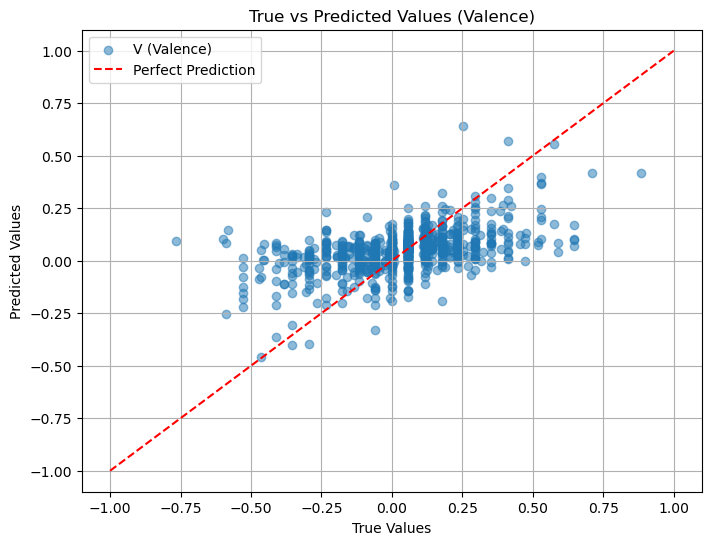

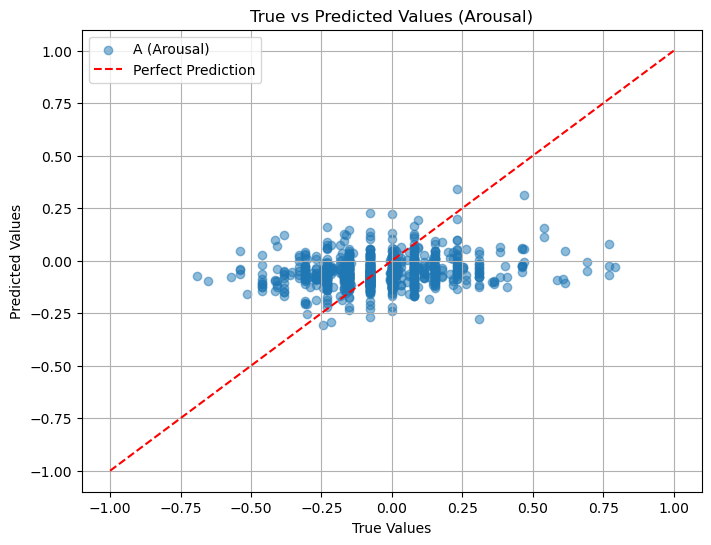

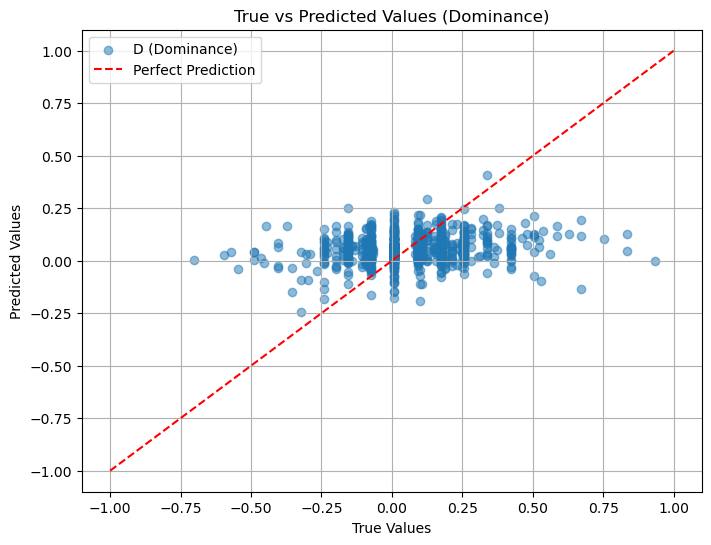

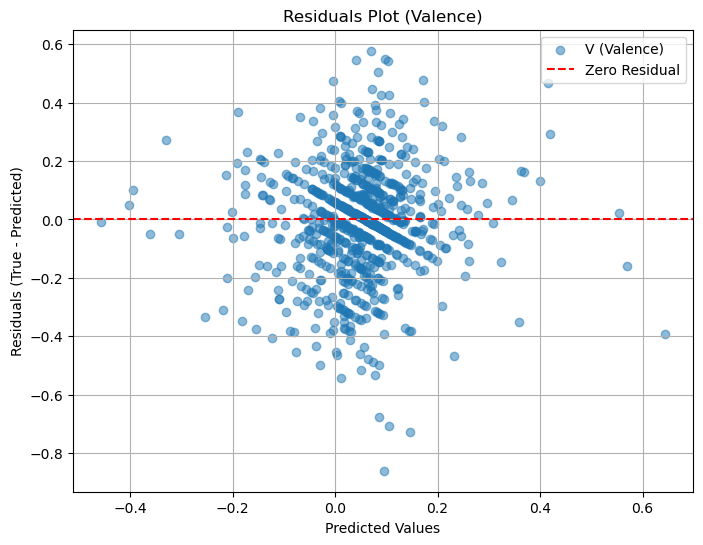

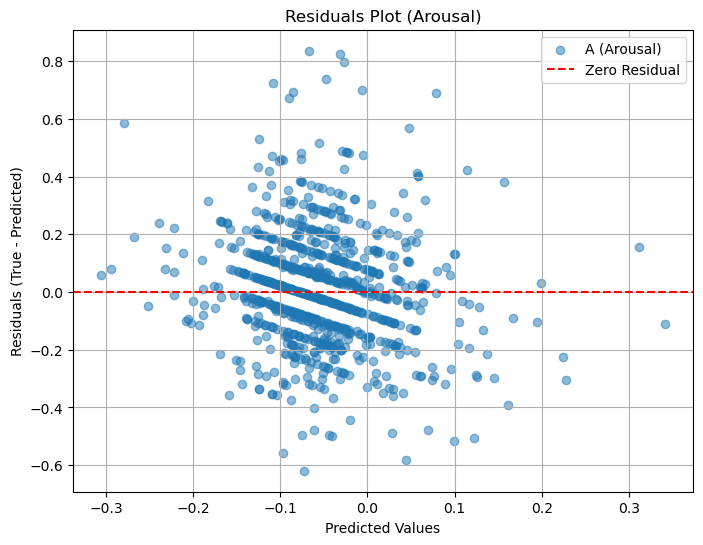

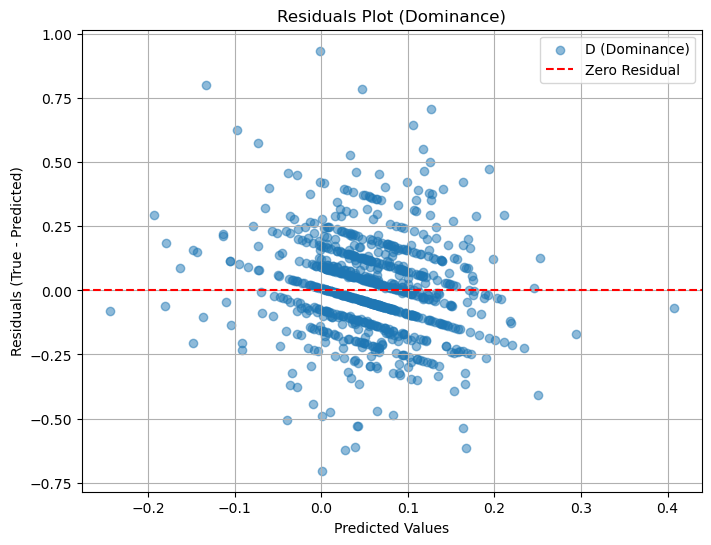

In [6]:
import matplotlib.pyplot as plt


def plot_predictions_single(y_true, y_pred, index, label, title=""):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true[:, index], y_pred[:, index], alpha=0.5, label=label)
    plt.plot([-1, 1], [-1, 1], color="red", linestyle="--", label="Perfect Prediction")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

# plots for residuals

def plot_residuals_single(y_true, y_pred, index, label, title=""):
    residuals = y_true[:, index] - y_pred[:, index]
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred[:, index], residuals, alpha=0.5, label=label)
    plt.axhline(0, color="red", linestyle="--", label="Zero Residual")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (True - Predicted)")
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

# Convert pandas DataFrame to numpy array for plotting
y_val_np = y_val.values
y_val_pred_np = y_val_pred

# Plot predictions for each dimension
plot_predictions_single(y_val_np, y_val_pred_np, 0, "V (Valence)", title="True vs Predicted Values (Valence)")
plot_predictions_single(y_val_np, y_val_pred_np, 1, "A (Arousal)", title="True vs Predicted Values (Arousal)")
plot_predictions_single(y_val_np, y_val_pred_np, 2, "D (Dominance)", title="True vs Predicted Values (Dominance)")

# Plot residuals for each dimension
plot_residuals_single(y_val_np, y_val_pred_np, 0, "V (Valence)", title="Residuals Plot (Valence)")
plot_residuals_single(y_val_np, y_val_pred_np, 1, "A (Arousal)", title="Residuals Plot (Arousal)")
plot_residuals_single(y_val_np, y_val_pred_np, 2, "D (Dominance)", title="Residuals Plot (Dominance)")
